In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.4 MB/s eta 0:00:0000:0100:01


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import SimpleITK as sitk
import cv2

import optuna 
import torch as tc
import torch.nn as nn
from torchvision import models
from monai.networks.nets import UNet
from monai.losses import DiceLoss

In [4]:
def get_files(data_path, folder):
    names = []
    folder_path = os.path.join(data_path, folder)
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        for file in os.listdir(subfolder_path):
            if file.endswith(".nrrd") and not file.endswith(".seg.nrrd"):
                names.append(os.path.join(subfolder_path, file))
    return names

def split_data(names_list, pre_test_size = 0.2, val_ratio = 0.5, seed=5):
    train_names, pre_test_names = train_test_split(names_list, test_size = pre_test_size, random_state = seed)
    val_names, test_names = train_test_split(pre_test_names, test_size = val_ratio, random_state = seed)
    return train_names, val_names, test_names
    
Data_path = r"/kaggle/input/mri-data/Data"

Dongyang_data_names = get_files(Data_path, "Dongyang")
KiTS_data_names = get_files(Data_path, "KiTS")
Rider_data_names = get_files(Data_path, "Rider")

D_train_names, D_val_names, D_test_names = split_data(Dongyang_data_names)
K_train_names, K_val_names, K_test_names = split_data(KiTS_data_names)
R_train_names, R_val_names, R_test_names = split_data(Rider_data_names)

train_data_names = D_train_names + K_train_names + R_train_names
val_data_names = D_val_names + K_val_names + R_val_names
test_data_names = D_test_names + K_test_names + R_test_names

In [5]:
class Dataset(tc.utils.data.Dataset):
    def __init__(self, data_names):
        self.images = []
        self.masks = []
        self.images_names = []
        self.borders = []
        
        slice_index = 0
        
        for name in data_names:
            self.borders.append("First slice of " + os.path.basename(name) + ": " + str(slice_index))
            
            image = sitk.ReadImage(name)
            image = sitk.GetArrayFromImage(image).T
            if image.shape[1] == 666:   #Normalize shape of data
                image = image[:, 77:589, :]
            for i in range(image.shape[2]):
                self.images.append(image[:, :, i])   #Adding every slice separately
                self.images_names.append(os.path.basename(name) + "Slice" + str(i))
                slice_index += 1
                
            mask_path = name.replace(".nrrd", ".seg.nrrd")   #The masks have the same name as the files but their format is different
            if not os.path.exists(mask_path):
                raise ValueError(f"There is no mask for file {os.path.basename(name)}")
                
            mask = sitk.ReadImage(mask_path)
            mask = sitk.GetArrayFromImage(mask).T
            if mask.shape[1] == 666:   #Normalize shape of mask
                mask = mask[:, 77:589, :]
            for i in range(mask.shape[2]):
                self.masks.append(mask[:, :, i])   #To match slices of data we also slice masks
            
    def Preprocess_Data(self):
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4, 4))
        for i in range(len(self.images)):
            image = self.images[i]
            if "R" in self.images_names[i]:   #Rider files have NaN values that are read as -2000
                image[image == -2000] = 0
            image = (image - np.min(image)) / (np.max(image) - np.min(image))   #Normalize to 0-1 range
            image = np.uint8(255*(image))   #Scale to uint8 in 0-255 range for CV2 functions
            image = cv2.resize(image, (224, 224)) 
            image = clahe.apply(image)   #Clahe increase the contrast
            self.images[i] = tc.from_numpy(np.float32(image)/255) #Preparing data so that the model can process it effectively
            
        for i in range(len(self.masks)):
            mask = self.masks[i]
            mask = cv2.resize(mask, (224, 224))
            mask = (mask > 0)
            self.masks[i] = tc.from_numpy(np.float32(mask))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index], self.masks[index]
        
    def Get_name(self, index):
        return self.images_names[index]
        
    def Get_borders(self):
        print(self.borders)

In [5]:
Testing_files = ['/kaggle/input/mri-data/Data/Dongyang/D6/D6.nrrd', 
                 '/kaggle/input/mri-data/Data/KiTS/K10/K10.nrrd', 
                 '/kaggle/input/mri-data/Data/Rider/R4/R4.nrrd']

Test_data = Dataset(Testing_files)
Test_data.Get_borders()

['First slice of D6.nrrd: 0', 'First slice of K10.nrrd: 159', 'First slice of R4.nrrd: 305']


Text(0.5, 1.0, 'R4 Preproccesed')

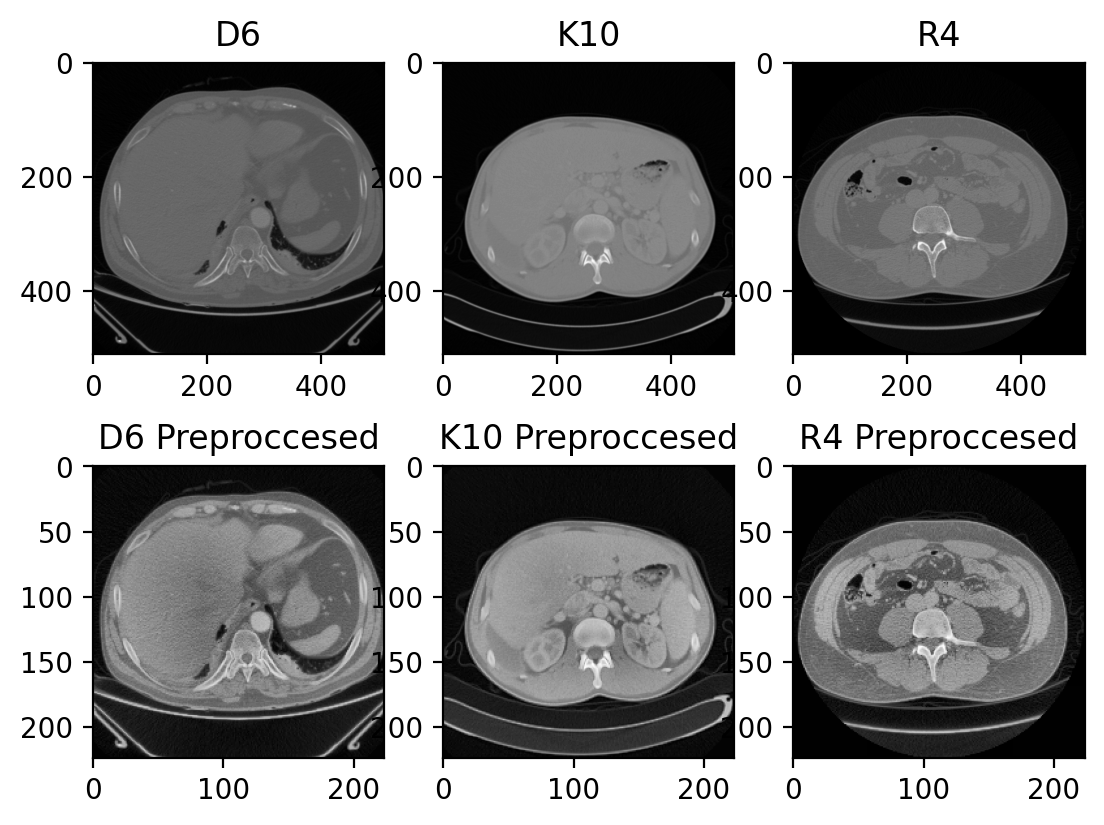

In [6]:
D6_slice = (Test_data[80])[0]
K10_slice = (Test_data[230])[0]
R4_slice = (Test_data[700])[0]

Test_data.Preprocess_Data()

D6_slice_Preprocessed = (Test_data[80])[0]
K10_slice_Preprocessed = (Test_data[230])[0]
R4_slice_Preprocessed = (Test_data[700])[0]

plt.figure(dpi=200)
plt.subplot(2, 3, 1)
plt.imshow(D6_slice.T, cmap = "gray")
plt.title("D6")
plt.subplot(2, 3, 2)
plt.imshow(K10_slice.T, cmap = "gray")
plt.title("K10")
plt.subplot(2, 3, 3)
plt.imshow(R4_slice.T, cmap = "gray")
plt.title("R4")
plt.subplot(2, 3, 4)
plt.imshow(D6_slice_Preprocessed.T, cmap = "gray")
plt.title("D6 Preproccesed")
plt.subplot(2, 3, 5)
plt.imshow(K10_slice_Preprocessed.T, cmap = "gray")
plt.title("K10 Preproccesed")
plt.subplot(2, 3, 6)
plt.imshow(R4_slice_Preprocessed.T, cmap = "gray")
plt.title("R4 Preproccesed")

In [6]:
Training_dataset = Dataset(train_data_names)
Training_dataset.Preprocess_Data()

Validation_dataset = Dataset(val_data_names)
Validation_dataset.Preprocess_Data()

In [7]:
def Train_model(model, training_loader, validation_loader, learning_rate, num_epochs, mode = "Study"):
    objective_function = DiceLoss(sigmoid=True)
    optimizer = tc.optim.Adam(model.parameters(), lr=learning_rate)
    device = tc.device("cuda" if tc.cuda.is_available() else "cpu")
    model = model.to(device)
    
    losses = []
    val_losses = []

    print(f"Training Dataset size: {len(training_loader.dataset)}") if mode == "Training" else None
    for epoch in range(num_epochs):
        print(f"Current epoch: {epoch}") if mode == "Training" else None
        epoch_loss = 0.0
        val_epoch_loss = 0.0
        
        model.train()
        for images, masks in training_loader:
            images, masks = images.to(device), masks.to(device)
            output = model(images.unsqueeze(1))
            if isinstance(output, dict): 
                output = output["out"]
            loss = objective_function(output, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item() * images.size(0)

        model.eval()
        with tc.no_grad():
            for images, masks in validation_loader:
                images, masks = images.to(device), masks.to(device)
                output = model(images.unsqueeze(1))
                if isinstance(output, dict): 
                    output = output["out"]
                val_loss = objective_function(output, masks.unsqueeze(1))
                val_epoch_loss += val_loss.item() * images.size(0)

        epoch_loss = epoch_loss / len(training_loader.dataset)
        val_epoch_loss = val_epoch_loss / len(validation_loader.dataset)
        losses.append(epoch_loss)
        val_losses.append(val_epoch_loss)
        print(f"Current epoch loss: {epoch_loss}") if mode == "Training" else None
        print(f"Current validation epoch loss: {val_epoch_loss}") if mode == "Training" else None
    
    if mode == "Study":
        return val_losses[-1]
    elif mode == "Training":
        return epoch_loss, val_epoch_loss, model

In [7]:
def objective(trial):
    channels = trial.suggest_categorical("channels", [[16, 32, 64, 128], [16, 32, 64, 128, 256]])
    dropout = trial.suggest_float("dropout", 0.0, 0.2)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    num_epochs = trial .suggest_int("num_epochs", 2, 15)

    Training_loader = tc.utils.data.DataLoader(Training_dataset, batch_size=32, shuffle=True)
    Validation_loader = tc.utils.data.DataLoader(Validation_dataset, batch_size=32, shuffle=True)

    strides = (2,) * (len(channels) - 1)
    model = UNet(
        spatial_dims = 2,
        in_channels=1,
        out_channels=1,
        channels=channels,
        strides=strides,
        dropout=dropout
    )

    Final_val_loss = Train_model(model, Training_loader, Validation_loader, learning_rate, num_epochs, mode = "Study")
    return Final_val_loss


study = optuna.create_study(direction="minimize")  
study.optimize(objective, n_trials=20)
tc.cuda.empty_cache()
print("Best parameters:", study.best_trial.params)

[I 2025-04-09 18:40:15,787] A new study created in memory with name: no-name-64e994d9-8a77-4e39-8b09-3f5adff4a49b
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 32, 64, 128] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 32, 64, 128, 256] which is of type list.
  warnings.warn(message)
[I 2025-04-09 18:41:43,094] Trial 0 finished with value: 0.8393507438217 and parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.003131613912088849, 'learning_rate': 4.1796872027686495e-05, 'num_epochs': 7}. Best is trial 0 with value: 0.8393507438217.
[I 2025-04-09 18:44:03,013] Trial 1 finished with value: 0.309009315

Best parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.1335125986310068, 'learning_rate': 0.0011194715871824731, 'num_epochs': 13}


In [ ]:
Training_loader = tc.utils.data.DataLoader(Training_dataset, batch_size=32, shuffle=True)
Validation_loader = tc.utils.data.DataLoader(Validation_dataset, batch_size=32, shuffle=True)
learning_rate = 0.0011194
num_epochs = 13
model = UNet(
        spatial_dims = 2,
        in_channels=1,
        out_channels=1,
        channels=[16, 32, 64, 128, 256],
        strides= (2, 2, 2),
        dropout=0.13351
    )
epoch_loss_lst, val_epoch_loss_lst, model = Train_model(model, Training_loader, Validation_loader, learning_rate, num_epochs, mode = "Training")
tc.save(model.state_dict(), '/kaggle/working/UNet_trained.pth')
tc.cuda.empty_cache()

In [59]:
tc.cuda.empty_cache()

In [60]:
def objective_deeplabv3(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    num_epochs = trial .suggest_int("num_epochs", 2, 15)

    Training_loader = tc.utils.data.DataLoader(Training_dataset, batch_size=32, shuffle=True)
    Validation_loader = tc.utils.data.DataLoader(Validation_dataset, batch_size=32, shuffle=True)

    model = models.segmentation.deeplabv3_mobilenet_v3_large(weights=None, num_classes=1) 
    model.backbone._modules["0"]._modules["0"] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)

    Final_val_loss = Train_model(model, Training_loader, Validation_loader, learning_rate, num_epochs, mode = "Study")
    return Final_val_loss


study = optuna.create_study(direction="minimize")  
study.optimize(objective_deeplabv3, n_trials=10)  
tc.cuda.empty_cache()
print("Best parameters deeplabv3 not pretrained:", study.best_trial.params)

[I 2025-04-10 18:03:34,618] A new study created in memory with name: no-name-ecbd370a-cfa0-47db-97b6-890a5894d91a
[W 2025-04-10 18:03:39,745] Trial 0 failed with parameters: {'learning_rate': 1.5480880904693324e-05, 'num_epochs': 14} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-60-15d82b3cb8d3>", line 11, in objective_deeplabv3
    Final_val_loss = Train_model(model, Training_loader, Validation_loader, learning_rate, num_epochs, mode = "Study")
  File "<ipython-input-7-dbf9f68f1059>", line 26, in Train_model
    epoch_loss += loss.item() * images.size(0)
KeyboardInterrupt
[W 2025-04-10 18:03:39,746] Trial 0 failed with value None.


KeyboardInterrupt: 

In [ ]:
def objective_deeplabv3_pretrained(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    num_epochs = trial .suggest_int("num_epochs", 2, 20)

    Training_loader = tc.utils.data.DataLoader(Training_dataset, batch_size=32, shuffle=True)
    Validation_loader = tc.utils.data.DataLoader(Validation_dataset, batch_size=32, shuffle=True)

    model = models.segmentation.deeplabv3_mobilenet_v3_large(weights=DEFAULT, num_classes=2) 
    model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
    
    Final_val_loss = Train_model(model, Training_loader, Validation_loader, learning_rate, num_epochs, mode = "Study")
    return Final_val_loss


study = optuna.create_study(direction="minimize")  
study.optimize(objective_deeplabv3_pretrained, n_trials=10)  
print("Best parameters deeplabv3 pretrained:", study.best_trial.params)